# Solar Image Dataset Training

In [193]:
# importing modules
import os
import cv2

from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import tensorflow as tf
import pickle

from tensorflow.keras.layers import *
from tensorflow.keras import optimizers, layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import img_to_array, array_to_img, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from keras.callbacks import (ModelCheckpoint, EarlyStopping, TensorBoard,
    Callback, LearningRateScheduler)

# New Section

In [194]:
tf.version.VERSION

'2.10.1'

In [195]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [196]:
print("Number of GPU Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Number of GPU Available:  1


In [197]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0']

## Dataset

In [198]:
DATASET_PATH = '/sol_data_splitted'

IMAGE_SIZE = 256
CHANNELS = 3
BATCH_SIZE = 64
EPOCHS = 53

input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
weight_decay = 0.005
learning_rate = 0.05
lr_decay = 1e-6
lr_drop = 25

In [199]:
def lr_scheduler(epoch):
    return learning_rate * (0.5 ** (epoch // lr_drop))
reduce_lr = LearningRateScheduler(lr_scheduler)

In [200]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    '../sol_data_splitted/train',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

Found 606 images belonging to 4 classes.


In [201]:
class_names = list(train_generator.class_indices.keys())
class_names

['clean', 'dust', 'shadow', 'waterdrop']

In [202]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    '../sol_data_splitted/val',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

Found 74 images belonging to 4 classes.


In [203]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '../sol_data_splitted/test',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

Found 80 images belonging to 4 classes.


In [204]:
for image_batch, label_batch in train_generator:
    print(image_batch.shape)
    break

(64, 256, 256, 3)


## Model Training

Models are:
- Sequential CNN
- AlexNet
- VGG16 (Transfer Learning)
- VGG16
- ResNet
- Xception
- Inception

In [205]:
!mkdir checkpoint

A subdirectory or file checkpoint already exists.


In [206]:
# Setting checkpoint & early stopping
checkpoint_path = os.path.join('/checkpoint',
                    'model_best_weights.{epoch:02d}-{accuracy:.4f}.hdf5')
checkpoint = ModelCheckpoint(
    checkpoint_path, monitor='accuracy',
    verbose=1, save_best_only=True, mode='max')

early_stop = EarlyStopping(monitor='accuracy', patience=5, mode='max')
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
    histogram_freq=1)
callbacks_list = [checkpoint, tensorboard_callback, reduce_lr]

In [207]:
def plot_accuracy(history, model_name=None):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    font = {'family': 'Times New Roman', 'size': 22}
    import matplotlib
    matplotlib.rc('font', **font)
    
    plt.figure(figsize=(25, 8))
    plt.subplot(1, 2, 1)
    plt.plot(range(EPOCHS), acc, label='Training Accuracy')
    plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(
        f'Training and Validation Accuracy for {model_name if model_name else ""}')

    plt.subplot(1, 2, 2)
    plt.plot(range(EPOCHS), loss, label='Training Loss')
    plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(
        f'Training and Validation Loss for {model_name if model_name else ""}')
    
    plt.show()

### Power-Net

In [208]:
model = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(2, 2),
    Conv2D(64,  kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(96,  kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(96, (4, 4), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(96, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(weight_decay)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(weight_decay)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(weight_decay)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(4, activation='softmax'),
])

In [209]:
model.build(input_shape=input_shape)

In [210]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_49 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 127, 127, 64)      18496     
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 63, 63, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, 63, 63, 96)        55392     
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 31, 31, 96)      

In [211]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [212]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_generator
)

Epoch 1/53
10/10 [==============================] - 20s 2s/step - loss: 2.7317 - accuracy: 0.3168 - val_loss: 2.3713 - val_accuracy: 0.3378
Epoch 2/53
10/10 [==============================] - 17s 2s/step - loss: 2.0947 - accuracy: 0.3317 - val_loss: 1.7015 - val_accuracy: 0.3378
Epoch 3/53
10/10 [==============================] - 18s 2s/step - loss: 1.5993 - accuracy: 0.3861 - val_loss: 1.3284 - val_accuracy: 0.4730
Epoch 4/53
10/10 [==============================] - 17s 2s/step - loss: 1.2256 - accuracy: 0.5050 - val_loss: 0.9837 - val_accuracy: 0.5676
Epoch 5/53
10/10 [==============================] - 19s 2s/step - loss: 1.0107 - accuracy: 0.5858 - val_loss: 0.9607 - val_accuracy: 0.5811
Epoch 6/53
10/10 [==============================] - 20s 2s/step - loss: 0.9595 - accuracy: 0.5809 - val_loss: 0.9040 - val_accuracy: 0.5541
Epoch 7/53
10/10 [==============================] - 19s 2s/step - loss: 0.8928 - accuracy: 0.5495 - val_loss: 0.8292 - val_accuracy: 0.6757
Epoch 8/53
10/10 [==

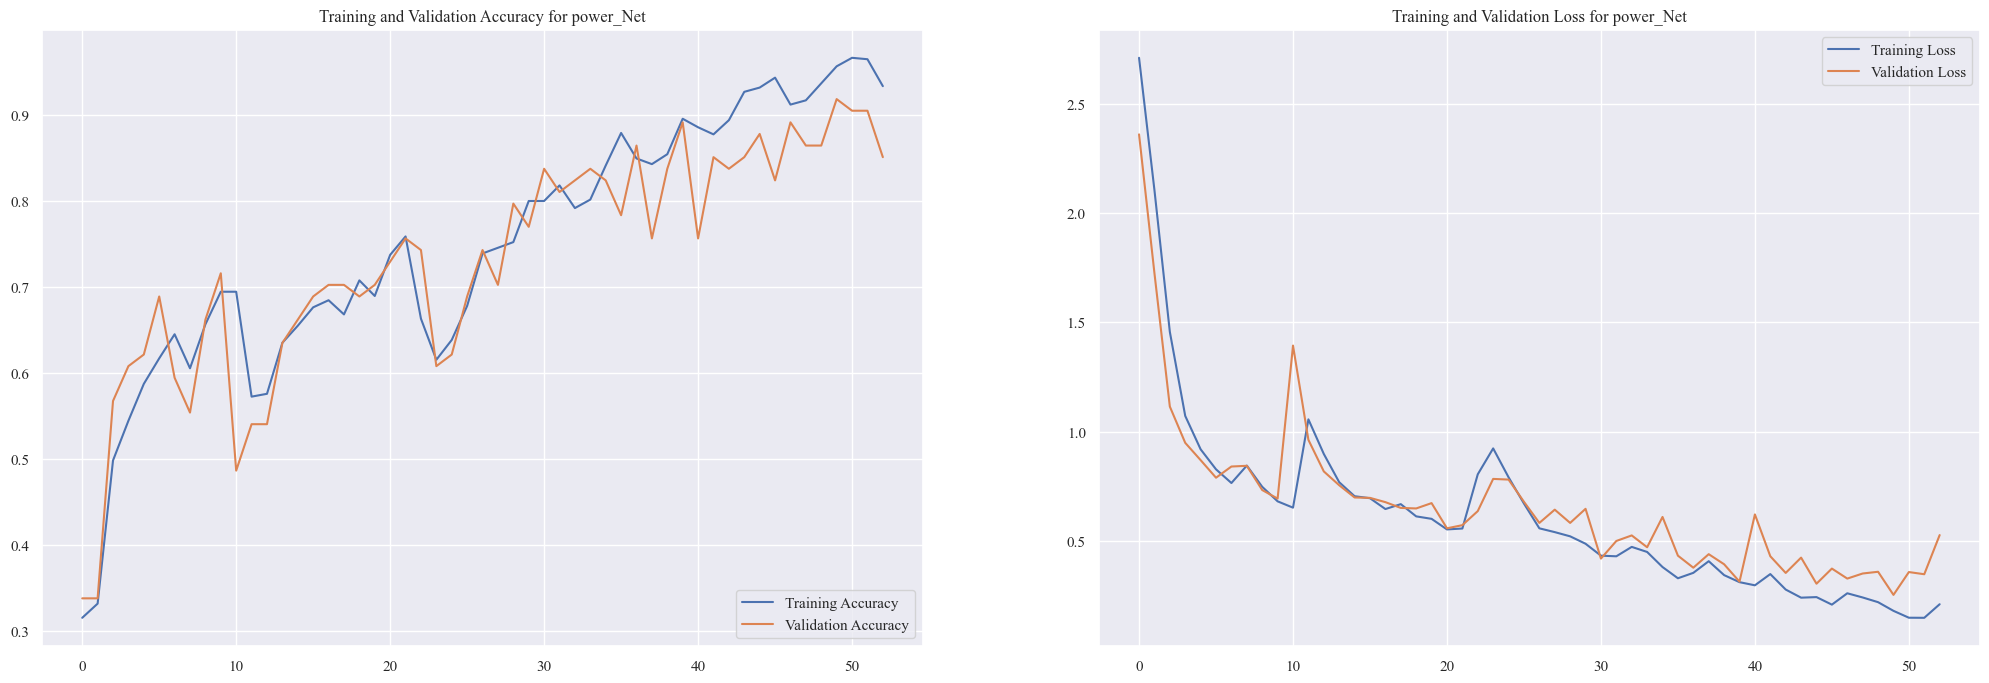

In [192]:
plot_accuracy(history, 'power_Net')

In [122]:
scores= model.evaluate(test_generator)
scores

2/2 [==============================] - 2s 360ms/step - loss: 0.2265 - accuracy: 0.9500


[0.22650015354156494, 0.949999988079071]

In [123]:
history.params

{'verbose': 1, 'epochs': 55, 'steps': 10}

In [124]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [125]:
len(history.history)

4

In [126]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [127]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 21ms/step


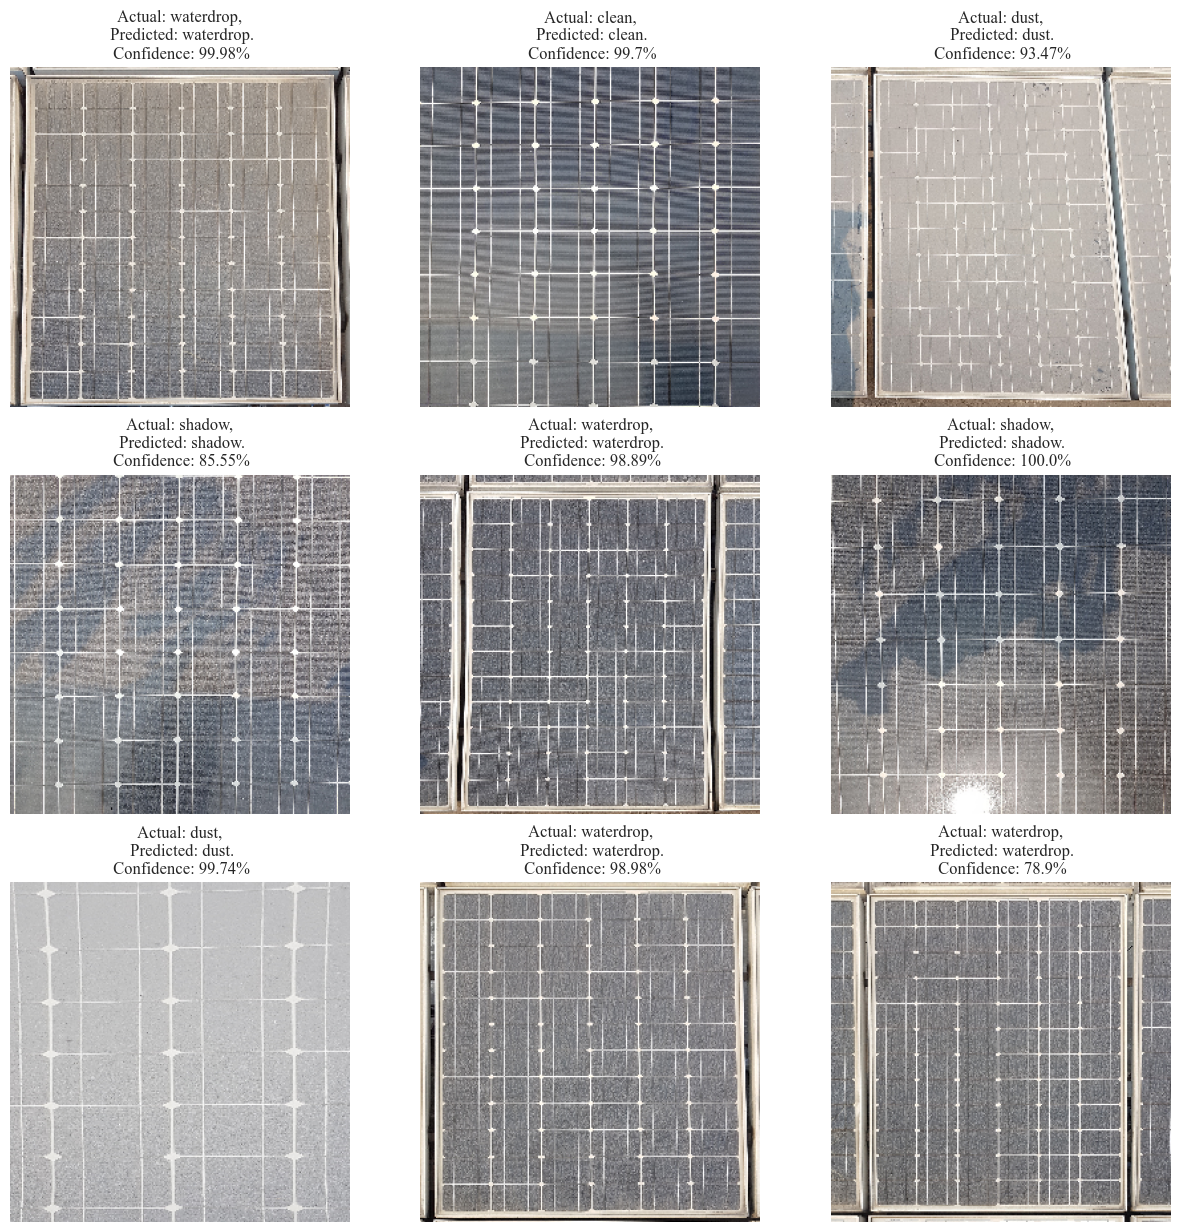

In [128]:
plt.figure(figsize=(15, 15))
for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[int(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break

In [129]:
model_version=max([int(i) for i in os.listdir("../save_solar_models") + [0]])+1
model.save(f"../save_solar_models/{model_version}")

INFO:tensorflow:Assets written to: ../save_solar_models/3\assets


INFO:tensorflow:Assets written to: ../save_solar_models/3\assets


In [130]:
model.save("../save_model_pc.h5")

In [131]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

df = pd.DataFrame(data={ 'training_acc': train_acc, 'val_acc': val_acc, 'training_loss': train_loss, 'val_loss': val_loss })
df.head()

,training_acc,val_acc,training_loss,val_loss
0,0.331683,0.337838,2.688220,2.285987
1,0.424092,0.527027,1.907841,1.724355
2,0.547855,0.567568,1.371329,1.135481
3,0.572607,0.581081,1.085360,1.025046
4,0.587459,0.621622,0.976383,0.904345


In [132]:
df.to_csv('acl-net-mri-image.csv', index=False)

### REGRESSION

In [133]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [134]:
df = pd.read_csv("./metadataclean.csv")
df.head(10)

,Unnamed: 0,panel_name,image_name,lebel,time,LUX,TEMP (Celcius),power
0,0,d-1-3-1,d-1-3-1.jpg,d,1,1350,27.0,23.4639
1,1,d-1-3-2,d-1-3-2.jpg,d,1,1350,27.0,23.4639
2,2,d-1-3-3,d-1-3-3.jpg,d,1,1350,27.0,23.4639
3,3,d-1-3-4,d-1-3-4.jpg,d,1,1350,27.0,23.4639
4,4,d-1-4-1,d-1-4-1.jpg,d,1,2380,27.1,22.2275
5,5,d-1-4-2,d-1-4-2.jpg,d,1,2380,27.1,22.2275
6,6,d-1-4-3,d-1-4-3.jpg,d,1,2380,27.1,22.2275
7,7,d-1-4-4,d-1-4-4.jpg,d,1,2380,27.1,22.2275
8,8,d-1-5-1,d-1-5-1.jpg,d,1,1460,27.3,26.9468
9,9,d-1-5-2,d-1-5-2.jpg,d,1,1460,27.3,26.9468


In [135]:
df.drop(['Unnamed: 0'], axis = 1, inplace = True) 

In [136]:
df.head(10)

,panel_name,image_name,lebel,time,LUX,TEMP (Celcius),power
0,d-1-3-1,d-1-3-1.jpg,d,1,1350,27.0,23.4639
1,d-1-3-2,d-1-3-2.jpg,d,1,1350,27.0,23.4639
2,d-1-3-3,d-1-3-3.jpg,d,1,1350,27.0,23.4639
3,d-1-3-4,d-1-3-4.jpg,d,1,1350,27.0,23.4639
4,d-1-4-1,d-1-4-1.jpg,d,1,2380,27.1,22.2275
5,d-1-4-2,d-1-4-2.jpg,d,1,2380,27.1,22.2275
6,d-1-4-3,d-1-4-3.jpg,d,1,2380,27.1,22.2275
7,d-1-4-4,d-1-4-4.jpg,d,1,2380,27.1,22.2275
8,d-1-5-1,d-1-5-1.jpg,d,1,1460,27.3,26.9468
9,d-1-5-2,d-1-5-2.jpg,d,1,1460,27.3,26.9468


In [137]:
le = LabelEncoder()
df['lebel'] = le.fit_transform(df['lebel'])

In [138]:
X = df[['lebel','time','LUX','TEMP (Celcius)']]
y = df['power']

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [140]:
from sklearn.preprocessing import StandardScaler

In [141]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### RandomForestRegressor

In [142]:
from sklearn import externals

In [143]:
# import joblib
from sklearn.ensemble import RandomForestRegressor

In [144]:
rfr = RandomForestRegressor(n_estimators=100)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

In [145]:
from sklearn.metrics import mean_squared_error, r2_score
print("Mean squared error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))

Mean squared error: 0.373424241742119
R-squared: 0.9990843067788965


In [146]:
with open("rf_model.pkl", "wb") as file:
    pickle.dump(rfr, file)

In [147]:
with open("rf_model.pkl", "rb") as file:
    rf_model = pickle.load(file)

In [148]:
cnn_model = tf.keras.models.load_model('./save_model.h5')

In [149]:
# filename = 'RandomForestRegressor_model.joblib'
# joblib.dump(rfr, filename)

# # load the model from disk
# loaded_model = joblib.load(filename)

In [150]:
def power_regression_prediction(lebel, time, lux, temp):
    user_input = [[lebel, time, lux, temp]]
    user_input = scaler.transform(user_input)
    power_prediction = rf_model.predict(user_input)
    return power_prediction[0]

In [151]:
from PIL import Image
import numpy as np

def predict_power(image_path, time, lux, temp):
    # Open and preprocess the image
    image = Image.open(image_path)
    image = image.resize((256, 256))
    image_array = np.array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)
    class_names=['clean', 'dust', 'shadow', 'waterdrop']
    # Use the CNN model to predict the label of the image
    label_prediction = cnn_model.predict(image_array)
    label = np.argmax(label_prediction)

    # Use the predicted label, time, lux, and temp to predict the power
    power_prediction = power_regression_prediction(label, time, lux, temp)
    return class_names[label], power_prediction

In [155]:
power_prediction = predict_power(r"D:\400c_data\project\sol_data_splitted\test\dust\d-3-20-2.jpg", 3, 2800, 26)
print("Predicted power:", power_prediction)

1/1 [==============================] - 0s 21ms/step
Predicted power: ('dust', 24.635325000000016)


D:\400c_data\project\venv\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
# def predict_panel(image, time, lux, temp):
#     img_array = tf.keras.preprocessing.image.img_to_array(image)
#     img_array = tf.expand_dims(img_array, 0)

#     predicted = cnn_model.predict(img_array)
#     class_names=['clean', 'dust', 'shadow', 'waterdrop']
#     class_label=[1, 2, 3, 4]
#     label = class_label[np.argmax(predicted[0])]

#     X_test = np.array([[label, time, lux, temp]])
#     # power_pred = rf_model.predict(X_test)
#     power_pred=rfr.predict(X_test)
#     return class_names[label-1], power_pred


In [ ]:
# import cv2
# im = cv2.imread("/content/sol_data_splitted/train/waterdrop/w-1-6-2.jpg")
# images = cv2.resize(im, (256, 256))
# images = images.astype("float") / 255.0

In [ ]:
# predict_panel(images, 2, 3000, 30)

1/1 [==============================] - 0s 70ms/step


('clean', array([83.600662]))

### Prediction Function

### AlexNet

In [ ]:
i = Input(input_shape)
r = Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu',
                  input_shape=input_shape)(i)
r = BatchNormalization()(r)
r = Dropout(0.2)(r)
r = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(r)
r = Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu',
                  padding="same")(r)
r = BatchNormalization()(r)
r = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(r)
r = Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation='relu',
                  padding="same")(r)
r = BatchNormalization()(r)
r = Dropout(0.4)(r)
r = Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation='relu',
                  padding="same")(r)
r = BatchNormalization()(r)
r = Dropout(0.5)(r)
r = Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu',
                  padding="same")(r)
r = BatchNormalization()(r)
r = Dropout(0.4)(r)
r = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(r)
r = Flatten()(r)
r = Dense(4096, activation='relu')(r)
r = Dropout(0.5)(r)
r = Dense(4096, activation='relu')(r)
r = Dropout(0.4)(r)
o = Dense(4, activation='softmax')(r)

alexnet_model = Model(i, o)

In [ ]:
alexnet_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
alexnet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_21 (Conv2D)          (None, 62, 62, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 96)       384       
 ormalization)                                                   
                                                                 
 dropout_3 (Dropout)         (None, 62, 62, 96)        0         
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 30, 30, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 30, 30, 256)       614656

In [ ]:
alexnet_history = alexnet_model.fit(
    train_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_generator
)

Epoch 1/50
10/10 [==============================] - 28s 3s/step - loss: 1.1906 - accuracy: 0.6337 - val_loss: 101.5601 - val_accuracy: 0.2162
Epoch 2/50
10/10 [==============================] - 29s 3s/step - loss: 0.9224 - accuracy: 0.6749 - val_loss: 54.7677 - val_accuracy: 0.2162
Epoch 3/50
10/10 [==============================] - 29s 3s/step - loss: 0.8496 - accuracy: 0.7178 - val_loss: 28.9591 - val_accuracy: 0.2162
Epoch 4/50
10/10 [==============================] - 28s 3s/step - loss: 0.8368 - accuracy: 0.7145 - val_loss: 14.4629 - val_accuracy: 0.1081
Epoch 5/50
10/10 [==============================] - 28s 3s/step - loss: 0.6955 - accuracy: 0.7013 - val_loss: 30.9162 - val_accuracy: 0.1081
Epoch 6/50
 1/10 [==>...........................] - ETA: 24s - loss: 0.5176 - accuracy: 0.7188

KeyboardInterrupt: ignored

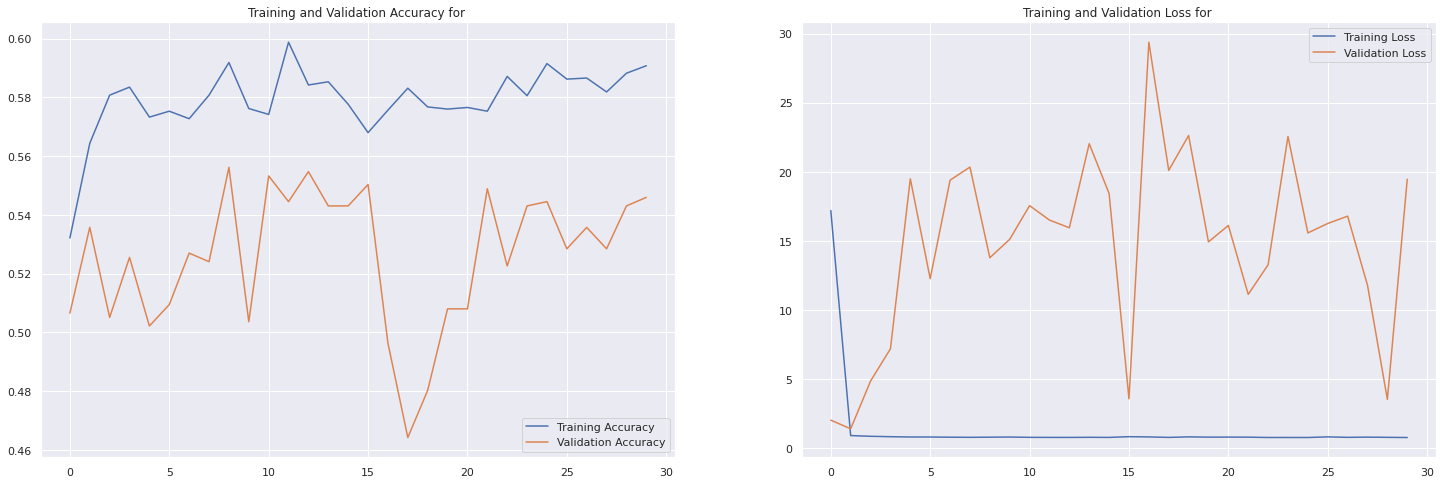

In [ ]:
plot_accuracy(alexnet_history)

In [ ]:
alexnet_scores= alexnet_model.evaluate(test_generator)
alexnet_scores

11/11 [==============================] - 4s 377ms/step - loss: 18.4491 - accuracy: 0.5712


[18.4490966796875, 0.5712209343910217]

In [ ]:
train_acc = alexnet_history.history['accuracy']
val_acc = alexnet_history.history['val_accuracy']

train_loss = alexnet_history.history['loss']
val_loss = alexnet_history.history['val_loss']

df = pd.DataFrame(data={ 'training_acc': train_acc, 'val_acc': val_acc, 'training_loss': train_loss, 'val_loss': val_loss })
df.head()

,training_acc,val_acc,training_loss,val_loss
0,0.532144,0.506569,17.194347,2.021484
1,0.564378,0.535766,0.905968,1.397085
2,0.580769,0.505109,0.854332,4.852070
3,0.583500,0.525547,0.825905,7.188923
4,0.573302,0.502190,0.804347,19.491945


In [ ]:
df.to_csv('MRI_alexnet_model.csv', index=False)

### VGG16

In [ ]:
vgg16_model = Sequential()

vgg16_model.add(Conv2D(64, (3, 3), padding='same', input_shape=input_shape))
vgg16_model.add(Activation('relu'))
vgg16_model.add(BatchNormalization())
vgg16_model.add(Dropout(0.3))

vgg16_model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
vgg16_model.add(Activation('relu'))
vgg16_model.add(BatchNormalization())

vgg16_model.add(MaxPooling2D(pool_size=(2, 2)))

vgg16_model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
vgg16_model.add(Activation('relu'))
vgg16_model.add(BatchNormalization())
vgg16_model.add(Dropout(0.4))

vgg16_model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
vgg16_model.add(Activation('relu'))
vgg16_model.add(BatchNormalization())

vgg16_model.add(MaxPooling2D(pool_size=(2, 2)))

vgg16_model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
vgg16_model.add(Activation('relu'))
vgg16_model.add(BatchNormalization())
vgg16_model.add(Dropout(0.4))

vgg16_model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
vgg16_model.add(Activation('relu'))
vgg16_model.add(BatchNormalization())
vgg16_model.add(Dropout(0.4))

vgg16_model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
vgg16_model.add(Activation('relu'))
vgg16_model.add(BatchNormalization())
vgg16_model.add(MaxPooling2D(pool_size=(2, 2)))

vgg16_model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
vgg16_model.add(Activation('relu'))
vgg16_model.add(BatchNormalization())
vgg16_model.add(Dropout(0.4))

vgg16_model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
vgg16_model.add(Activation('relu'))
vgg16_model.add(BatchNormalization())
vgg16_model.add(Dropout(0.4))

vgg16_model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
vgg16_model.add(Activation('relu'))
vgg16_model.add(BatchNormalization())
vgg16_model.add(MaxPooling2D(pool_size=(2, 2)))

vgg16_model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
vgg16_model.add(Activation('relu'))
vgg16_model.add(BatchNormalization())
vgg16_model.add(Dropout(0.4))

vgg16_model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
vgg16_model.add(Activation('relu'))
vgg16_model.add(BatchNormalization())
vgg16_model.add(Dropout(0.4))

vgg16_model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
vgg16_model.add(Activation('relu'))
vgg16_model.add(BatchNormalization())
vgg16_model.add(MaxPooling2D(pool_size=(2, 2)))
vgg16_model.add(Dropout(0.5))

vgg16_model.add(Flatten())
vgg16_model.add(Dense(512))
vgg16_model.add(Activation('relu'))
vgg16_model.add(BatchNormalization())

vgg16_model.add(Dropout(0.5))
vgg16_model.add(Dense(3))
vgg16_model.add(Activation('softmax'))

In [ ]:
vgg16_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 activation (Activation)     (None, 256, 256, 64)      0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 64)     256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256, 256, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 activation_1 (Activation)   (None, 256, 256, 64)      0         
                                                        

In [ ]:
sgd = optimizers.SGD(learning_rate=learning_rate, decay=lr_decay,
                     momentum=0.8, nesterov=True)
vgg16_model.compile(loss='sparse_categorical_crossentropy',
                    optimizer=sgd, metrics=['accuracy'])

In [ ]:
vgg16_history = vgg16_model.fit(
    train_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_generator)

Epoch 1/30
86/86 [==============================] - 195s 2s/step - loss: 36.3751 - accuracy: 0.5250 - val_loss: 136.9079 - val_accuracy: 0.2759
Epoch 2/30
86/86 [==============================] - 133s 2s/step - loss: 25.3862 - accuracy: 0.5769 - val_loss: 21.8528 - val_accuracy: 0.3547
Epoch 3/30
86/86 [==============================] - 133s 2s/step - loss: 16.6116 - accuracy: 0.6616 - val_loss: 16.7186 - val_accuracy: 0.2818
Epoch 4/30
86/86 [==============================] - 133s 2s/step - loss: 11.0401 - accuracy: 0.7066 - val_loss: 22.0029 - val_accuracy: 0.3270
Epoch 5/30
86/86 [==============================] - 133s 2s/step - loss: 7.7412 - accuracy: 0.6665 - val_loss: 8.3298 - val_accuracy: 0.5299
Epoch 6/30
86/86 [==============================] - 133s 2s/step - loss: 5.3534 - accuracy: 0.7128 - val_loss: 7.7817 - val_accuracy: 0.3898
Epoch 7/30
86/86 [==============================] - 133s 2s/step - loss: 3.6653 - accuracy: 0.7563 - val_loss: 76.3229 - val_accuracy: 0.3372
Epo

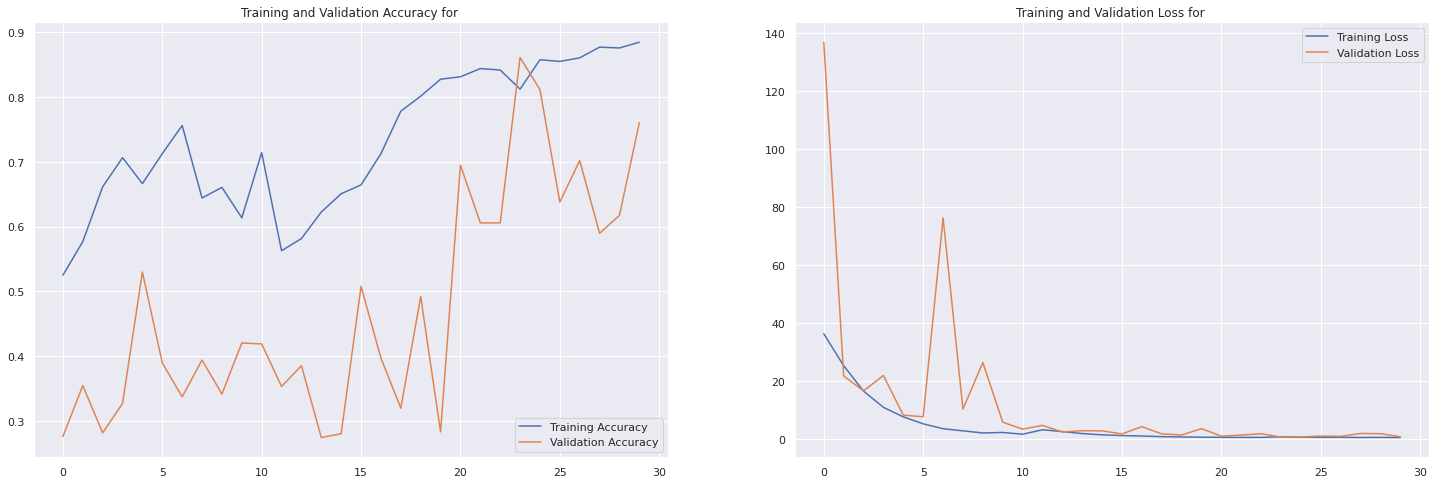

In [ ]:
plot_accuracy(vgg16_history)

In [ ]:
vgg16_scores= vgg16_model.evaluate(test_generator)
vgg16_scores

11/11 [==============================] - 16s 2s/step - loss: 0.8594 - accuracy: 0.7820


[0.8594195246696472, 0.7819767594337463]

### VGG16 Transfer Learning

In [ ]:
vgg16_tl = VGG16(input_shape=input_shape, weights='imagenet', include_top=False)
for layer in vgg16_tl.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
x = Flatten()(vgg16_tl.output)
prediction = Dense(3, activation='softmax')(x)

vgg16_tl_model = Model(inputs=vgg16_tl.input, outputs=prediction)

In [ ]:
vgg16_tl_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [ ]:
vgg16_tl_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
vgg16_tl_history = vgg16_tl_model.fit(
    train_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_generator)

Epoch 1/50
10/10 [==============================] - 39s 3s/step - loss: nan - accuracy: 0.2360 - val_loss: nan - val_accuracy: 0.2162
Epoch 2/50
10/10 [==============================] - 29s 3s/step - loss: nan - accuracy: 0.2211 - val_loss: nan - val_accuracy: 0.2162
Epoch 3/50
10/10 [==============================] - 29s 3s/step - loss: nan - accuracy: 0.2211 - val_loss: nan - val_accuracy: 0.2162
Epoch 4/50
10/10 [==============================] - 32s 3s/step - loss: nan - accuracy: 0.2211 - val_loss: nan - val_accuracy: 0.2162
Epoch 5/50
10/10 [==============================] - 29s 3s/step - loss: nan - accuracy: 0.2211 - val_loss: nan - val_accuracy: 0.2162
Epoch 6/50
10/10 [==============================] - 30s 3s/step - loss: nan - accuracy: 0.2211 - val_loss: nan - val_accuracy: 0.2162
Epoch 7/50
 5/10 [==============>...............] - ETA: 11s - loss: nan - accuracy: 0.1818

KeyboardInterrupt: ignored

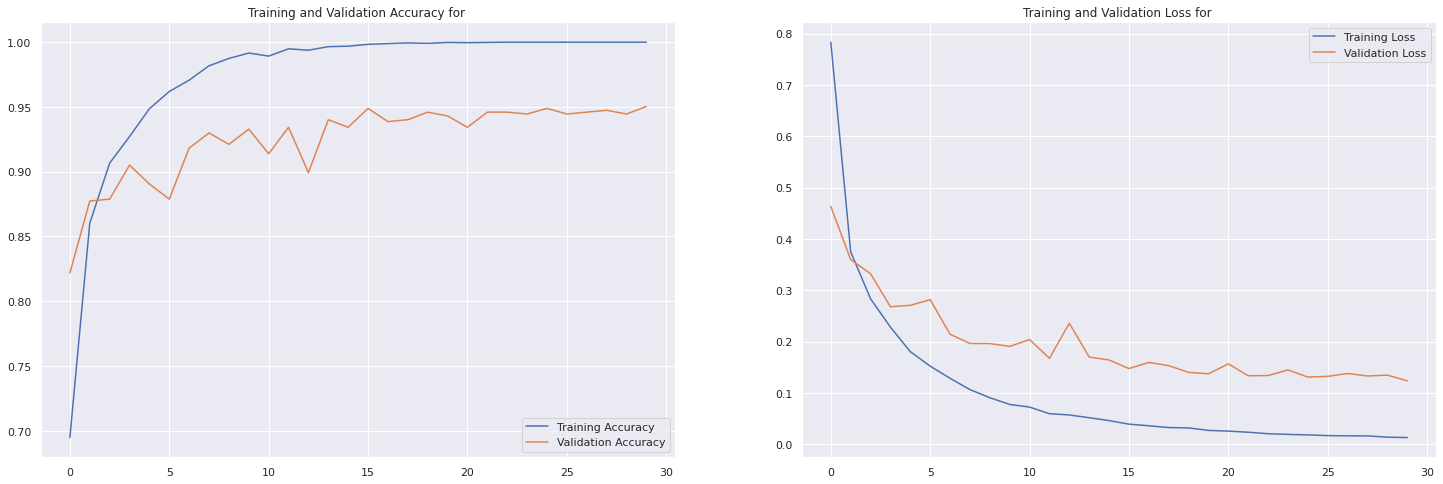

In [ ]:
plot_accuracy(vgg16_tl_history)

In [ ]:
vgg16_tl_scores= vgg16_tl_model.evaluate(test_generator)
vgg16_tl_scores

11/11 [==============================] - 11s 1s/step - loss: 0.0930 - accuracy: 0.9593


[0.09300528466701508, 0.9593023061752319]

### ResNet

In [ ]:
def resnet(input_shape, n_classes):
  
    def conv_bn_rl(x, f, k=1, s=1, p='same'):
        x = Conv2D(f, k, strides=s, padding=p)(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = ReLU()(x)
        return x


    def identity_block(tensor, f):
        x = conv_bn_rl(tensor, f)
        x = conv_bn_rl(x, f, 3)
        x = Conv2D(4*f, 1)(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)

        x = Add()([x, tensor])
        output = ReLU()(x)
        return output


    def conv_block(tensor, f, s):
        x = conv_bn_rl(tensor, f)
        x = conv_bn_rl(x, f, 3, s)
        x = Conv2D(4*f, 1)(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)

        shortcut = Conv2D(4*f, 1, strides=s)(tensor)
        shortcut = BatchNormalization()(shortcut)

        x = Add()([x, shortcut])
        output = ReLU()(x)
        return output


    def resnet_block(x, f, r, s=2):
        x = conv_block(x, f, s)
        for _ in range(r-1):
            x = identity_block(x, f)
        return x


    input = Input(input_shape)

    x = conv_bn_rl(input, 64, 7, 2)
    x = MaxPool2D(3, strides=2, padding='same')(x)

    x = resnet_block(x, 64, 3, 1)
    x = resnet_block(x, 128, 4)
    x = resnet_block(x, 256, 6)
    x = resnet_block(x, 512, 3)

    x = GlobalAvgPool2D()(x)

    output = Dense(n_classes, activation='softmax')(x)

    model = Model(input, output)
    return model

In [ ]:
resnet_model = resnet(input_shape, 3)

In [ ]:
resnet_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
resnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 128, 128, 64  9472        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d_6[0][0]']               
 alization)                     )                                                           

In [ ]:
resnet_history = resnet_model.fit(
    train_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_generator
)

Epoch 1/30
86/86 [==============================] - 120s 1s/step - loss: 1.3613 - accuracy: 0.3724 - val_loss: 3.9548 - val_accuracy: 0.3883
Epoch 2/30
86/86 [==============================] - 99s 1s/step - loss: 0.8749 - accuracy: 0.6012 - val_loss: 25.2290 - val_accuracy: 0.2745
Epoch 3/30
86/86 [==============================] - 99s 1s/step - loss: 0.7176 - accuracy: 0.7092 - val_loss: 16.2373 - val_accuracy: 0.2745
Epoch 4/30
86/86 [==============================] - 99s 1s/step - loss: 0.6444 - accuracy: 0.7436 - val_loss: 12.1967 - val_accuracy: 0.2745
Epoch 5/30
86/86 [==============================] - 99s 1s/step - loss: 0.6172 - accuracy: 0.7552 - val_loss: 23.2995 - val_accuracy: 0.2745
Epoch 6/30
86/86 [==============================] - 99s 1s/step - loss: 0.5638 - accuracy: 0.7813 - val_loss: 13.8630 - val_accuracy: 0.2745
Epoch 7/30
86/86 [==============================] - 99s 1s/step - loss: 0.5602 - accuracy: 0.7807 - val_loss: 14.9213 - val_accuracy: 0.2745
Epoch 8/30
86

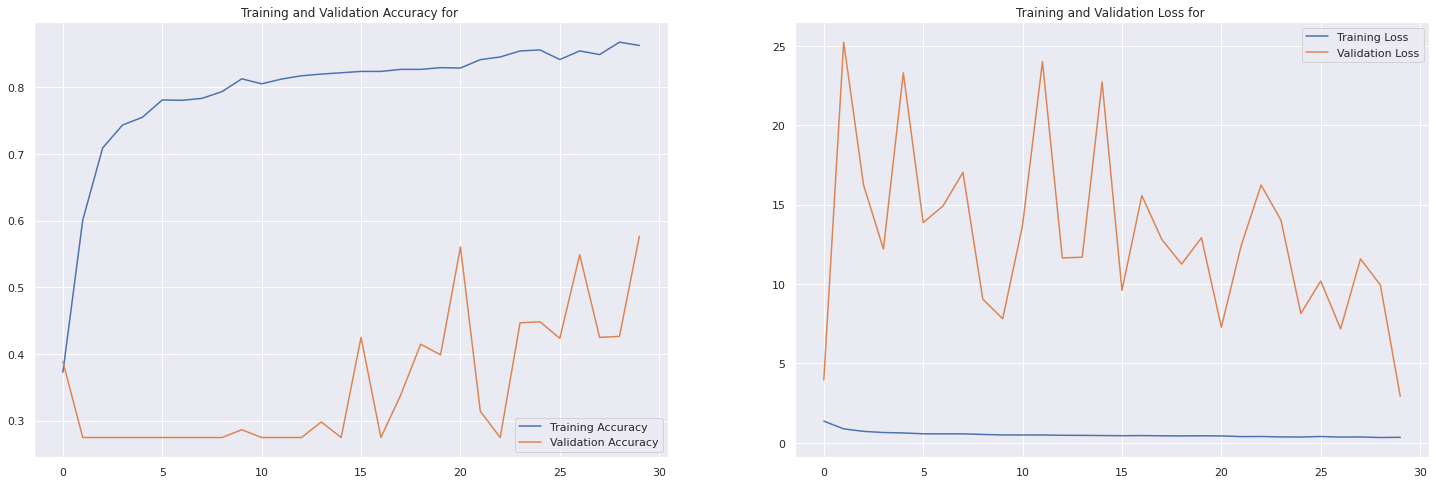

In [ ]:
plot_accuracy(resnet_history)

In [ ]:
resnet_scores= resnet_model.evaluate(test_generator)
resnet_scores

11/11 [==============================] - 5s 471ms/step - loss: 2.8986 - accuracy: 0.5945


[2.89855694770813, 0.5944767594337463]

### ResNet Transfer Learning

In [ ]:
ResNet50_tl=tf.keras.applications.ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
for layer in ResNet50_tl.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
x = Flatten()(ResNet50_tl.output)
prediction = Dense(3, activation='softmax')(x)

ResNet50_tl_model = Model(inputs=ResNet50_tl.input, outputs=prediction)

In [ ]:
ResNet50_tl_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
ResNet50_tl_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
ResNet50_tl_history = ResNet50_tl_model.fit(
    train_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_generator)

Epoch 1/30
86/86 [==============================] - 36s 376ms/step - loss: 2.7828 - accuracy: 0.4620 - val_loss: 0.9653 - val_accuracy: 0.4847
Epoch 2/30
86/86 [==============================] - 31s 358ms/step - loss: 1.0708 - accuracy: 0.5427 - val_loss: 1.9733 - val_accuracy: 0.4701
Epoch 3/30
86/86 [==============================] - 30s 353ms/step - loss: 1.1829 - accuracy: 0.5493 - val_loss: 1.3370 - val_accuracy: 0.5080
Epoch 4/30
86/86 [==============================] - 31s 353ms/step - loss: 0.8674 - accuracy: 0.6294 - val_loss: 1.0782 - val_accuracy: 0.5416
Epoch 5/30
86/86 [==============================] - 30s 351ms/step - loss: 1.2366 - accuracy: 0.5753 - val_loss: 0.6966 - val_accuracy: 0.7153
Epoch 6/30
86/86 [==============================] - 31s 354ms/step - loss: 0.8205 - accuracy: 0.6560 - val_loss: 0.6783 - val_accuracy: 0.7372
Epoch 7/30
86/86 [==============================] - 30s 352ms/step - loss: 0.7835 - accuracy: 0.6718 - val_loss: 0.9541 - val_accuracy: 0.6073

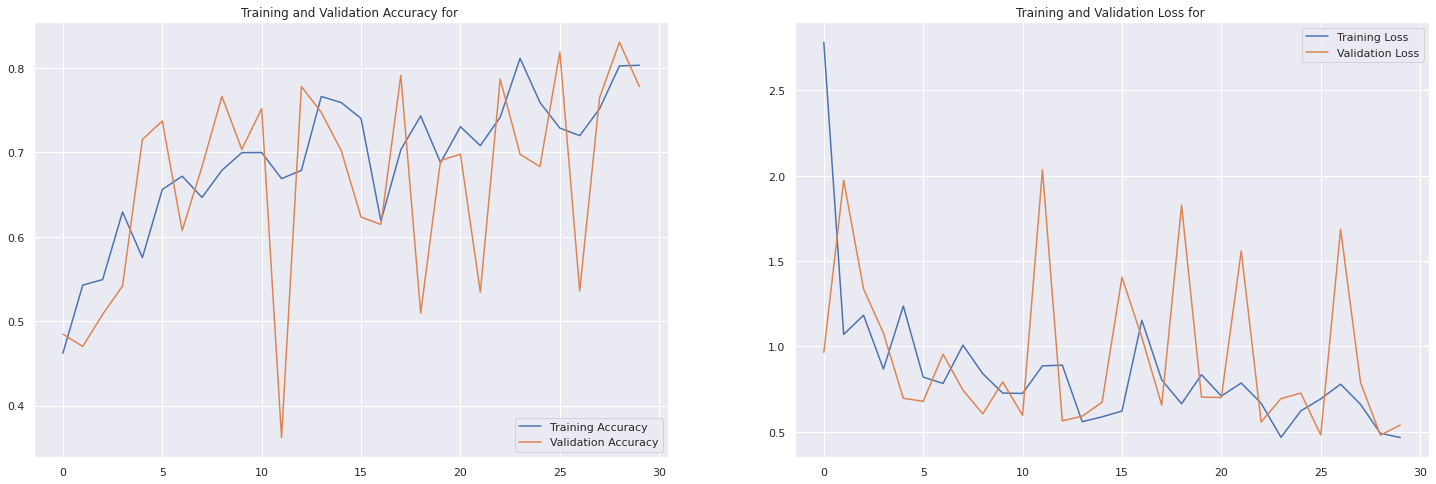

In [ ]:
plot_accuracy(ResNet50_tl_history)

In [ ]:
ResNet50_tl_scores= ResNet50_tl_model.evaluate(test_generator)
ResNet50_tl_scores

11/11 [==============================] - 4s 309ms/step - loss: 0.5050 - accuracy: 0.7965


[0.5050237774848938, 0.7965116500854492]

### InceptionV3-14 Model

In [ ]:
InceptionV3_tl=tf.keras.applications.InceptionV3(input_shape=input_shape, weights='imagenet', include_top=False)
for layer in InceptionV3_tl.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 3s 0us/step


In [ ]:
x = Flatten()(InceptionV3_tl.output)
prediction = Dense(3, activation='softmax')(x)

InceptionV3_tl_model = Model(inputs=InceptionV3_tl.input, outputs=prediction)

In [ ]:
InceptionV3_tl_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_59 (Conv2D)             (None, 127, 127, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_53 (BatchN  (None, 127, 127, 32  96         ['conv2d_59[0][0]']              
 ormalization)                  )                                                           

In [ ]:
InceptionV3_tl_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
InceptionV3_tl_history = InceptionV3_tl_model.fit(
    train_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_generator)

Epoch 1/30
86/86 [==============================] - 39s 387ms/step - loss: 4.1218 - accuracy: 0.6440 - val_loss: 0.8514 - val_accuracy: 0.7854
Epoch 2/30
86/86 [==============================] - 28s 328ms/step - loss: 0.4350 - accuracy: 0.8579 - val_loss: 0.5330 - val_accuracy: 0.8482
Epoch 3/30
86/86 [==============================] - 28s 326ms/step - loss: 0.1614 - accuracy: 0.9437 - val_loss: 0.6418 - val_accuracy: 0.8307
Epoch 4/30
86/86 [==============================] - 28s 326ms/step - loss: 0.0579 - accuracy: 0.9803 - val_loss: 0.4819 - val_accuracy: 0.8453
Epoch 5/30
86/86 [==============================] - 28s 326ms/step - loss: 0.0688 - accuracy: 0.9740 - val_loss: 0.4516 - val_accuracy: 0.8701
Epoch 6/30
86/86 [==============================] - 28s 330ms/step - loss: 0.0176 - accuracy: 0.9962 - val_loss: 0.4242 - val_accuracy: 0.8818
Epoch 7/30
86/86 [==============================] - 28s 326ms/step - loss: 0.0068 - accuracy: 0.9998 - val_loss: 0.4332 - val_accuracy: 0.8774

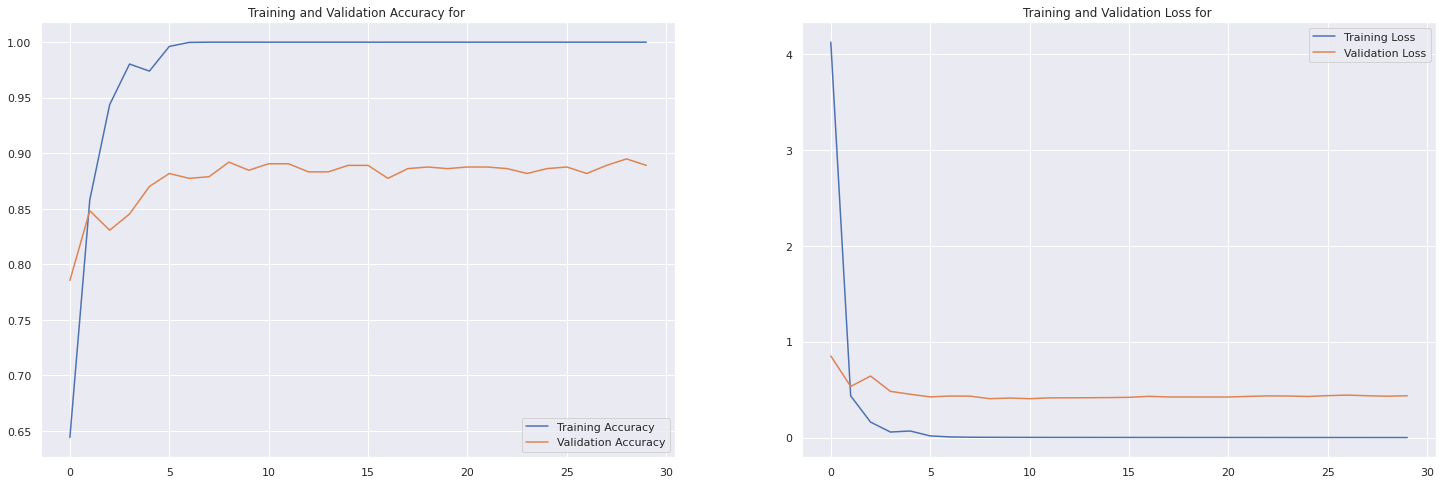

In [ ]:
plot_accuracy(InceptionV3_tl_history)

In [ ]:
InceptionV3_tl_scores= InceptionV3_tl_model.evaluate(test_generator)
InceptionV3_tl_scores

11/11 [==============================] - 5s 471ms/step - loss: 0.3240 - accuracy: 0.9055


[0.3240348696708679, 0.9055232405662537]